# Forecast EDA Superstore Sales

References
1. ML Mastery - 11 Classic Forecasting Models in Python  
https://machinelearningmastery.com/time-series-forecasting-methods-in-python-cheat-sheet/


2.  How to convert timeseries to Supervised Learning   
https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/ 


3. Model Warm Start ... update model training   
https://towardsdatascience.com/how-to-add-new-data-to-a-pretrained-model-in-scikit-learn-ce16911afe33


4. forecasting superstore sales with LSTM  
https://towardsdatascience.com/an-end-to-end-project-on-time-series-analysis-and-forecasting-with-python-4835e6bf050b 

Summary
  * Ref 1, Classical Models
  * Ref 2, This method is used as a basis for handling autoregressive variables
  * Ref 3, Model warm start method
  * Ref 4: Superstore Sales dataset, good yet small and contains co-variates


# Imports

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import beautifulplots as bp
import xlrd
from datetime import datetime
import sforecast as sf

pd.set_option('display.max_colwidth', 100)
pd.set_option('display.max_rows',20)
pd.set_option('display.max_columns', None)

# Load Data and Pre-Process

In [2]:
def yearweek_monday_datetime(row,year,week):
    y = str(row[year])
    w = str(row[week])
    y_w = f'{y} {w}'
    yearweek_dt = datetime.strptime(y_w + ' 1', "%Y %W %w") # Monday of week#
    return yearweek_dt

def date_to_yearweek_dt(df,year="year", week="week"):
    return df.apply(lambda row: yearweek_monday_datetime(row,year,week),axis=1)

In [3]:
df = pd.read_excel("../data/Superstore_2017.xls", parse_dates = ["Order Date"])
print(list(df.columns))

display(df.describe())
print("\ndf")
display(df.head(5))

display(df.groupby("Sub-Category")["Product ID"].count())

cols = ["Order Date", "Category", "Sub-Category", "Product ID" ,"Sales", "Quantity"]
df_sales = df[cols].copy()
df_sales["Price"] = df_sales["Sales"]/df_sales['Quantity']
df_sales["Price"] = df_sales["Sales"]/df_sales['Quantity']
df_sales = df_sales.sort_values("Order Date",ascending=True)
df_sales["year"]=df_sales["Order Date"].dt.year
df_sales['month']=df_sales["Order Date"].dt.month 
# do yearmonth before adjusting year ... NOTE yearmonth is needed for joining outside datasets like CCI
df_sales['yearmonth'] = df_sales['year']*100 + df_sales['month']
df_sales['week']=df_sales["Order Date"].dt.isocalendar().week 
df_sales['dayofweek']=df_sales["Order Date"].dt.dayofweek 
df_sales['dayname']=df_sales["Order Date"].dt.day_name()
# fix year and week ... 
  # weeks must be <= 52 ... 
df_sales['week']=df_sales['week'].apply(lambda x: x if x < 53 else 1) # isocalendar may have 53 weeks, adds a year to the date !!!!!
  # year = year-1 if week == 52 .... week may have started in previous year

df_sales['year']=df_sales.apply(lambda row: row["year"]-1  if (row["week"]==52 )and (row["month"]==1) else row["year"],axis=1)
df_sales['yearweek']= df_sales['year']*100+df_sales['week']  

df_sales["yearweek_dt"]=date_to_yearweek_dt(df_sales,year="year", week="week")
print("\ndf_sales (daily)")
display(df_sales.head())

aggs={
    "year":"last",
    "week":"last",
    "yearweek":"last",
    "yearmonth":"last",
    "Quantity":"sum",
    "Sales":"sum"
    
}

df_sales_week = df_sales.groupby(["yearweek_dt", "Category","Sub-Category", "Product ID"]).agg(aggs).reset_index()
print("\ndf_sales_week")
display(df_sales_week.head())


['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Sales', 'Quantity', 'Discount', 'Profit']


,Row ID,Postal Code,Sales,Quantity,Discount,Profit
count,9994.000000,9994.000000,9994.000000,9994.000000,9994.000000,9994.000000
mean,4997.500000,55190.379428,229.858001,3.789574,0.156203,28.656896
std,2885.163629,32063.693350,623.245101,2.225110,0.206452,234.260108
min,1.000000,1040.000000,0.444000,1.000000,0.000000,-6599.978000
25%,2499.250000,23223.000000,17.280000,2.000000,0.000000,1.728750
50%,4997.500000,56430.500000,54.490000,3.000000,0.200000,8.666500
75%,7495.750000,90008.000000,209.940000,5.000000,0.200000,29.364000
max,9994.000000,99301.000000,22638.480000,14.000000,0.800000,8399.976000



df


,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs, Rounded Back",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters by Universal,14.6200,2,0.00,6.8714
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


Sub-Category
Accessories     775
Appliances      466
Art             796
Binders        1523
Bookcases       228
Chairs          617
Copiers          68
Envelopes       254
Fasteners       217
Furnishings     957
Labels          364
Machines        115
Paper          1370
Phones          889
Storage         846
Supplies        190
Tables          319
Name: Product ID, dtype: int64


df_sales (daily)


,Order Date,Category,Sub-Category,Product ID,Sales,Quantity,Price,year,month,yearmonth,week,dayofweek,dayname,yearweek,yearweek_dt
7980,2014-01-03,Office Supplies,Paper,OFF-PA-10000174,16.448,2,8.224,2014,1,201401,1,4,Friday,201401,2014-01-06
739,2014-01-04,Office Supplies,Labels,OFF-LA-10003223,11.784,3,3.928,2014,1,201401,1,5,Saturday,201401,2014-01-06
740,2014-01-04,Office Supplies,Storage,OFF-ST-10002743,272.736,3,90.912,2014,1,201401,1,5,Saturday,201401,2014-01-06
741,2014-01-04,Office Supplies,Binders,OFF-BI-10004094,3.540,2,1.770,2014,1,201401,1,5,Saturday,201401,2014-01-06
1759,2014-01-05,Office Supplies,Art,OFF-AR-10003478,19.536,3,6.512,2014,1,201401,1,6,Sunday,201401,2014-01-06



df_sales_week


,yearweek_dt,Category,Sub-Category,Product ID,year,week,yearweek,yearmonth,Quantity,Sales
0,2014-01-06,Furniture,Bookcases,FUR-BO-10000362,2014,1,201401,201412,2,341.960
1,2014-01-06,Furniture,Bookcases,FUR-BO-10002613,2014,1,201401,201412,7,1573.488
2,2014-01-06,Furniture,Chairs,FUR-CH-10004218,2014,1,201401,201412,6,605.880
3,2014-01-06,Furniture,Furnishings,FUR-FU-10000193,2014,1,201401,201412,3,38.976
4,2014-01-06,Furniture,Furnishings,FUR-FU-10000550,2014,1,201401,201412,5,24.900


In [4]:
print(f'date min = {df_sales["Order Date"].min()}')
print(f'date max = {df_sales["Order Date"].max()}')
print(f'N days = {df_sales.shape[0]}')
print( f'N Product IDs = {df_sales.groupby("Product ID")["Sales"].count().count()} ')

date min = 2014-01-03 00:00:00
date max = 2017-12-30 00:00:00
N days = 9994
N Product IDs = 1862 


### Sales - Year, Category, Sub-Category

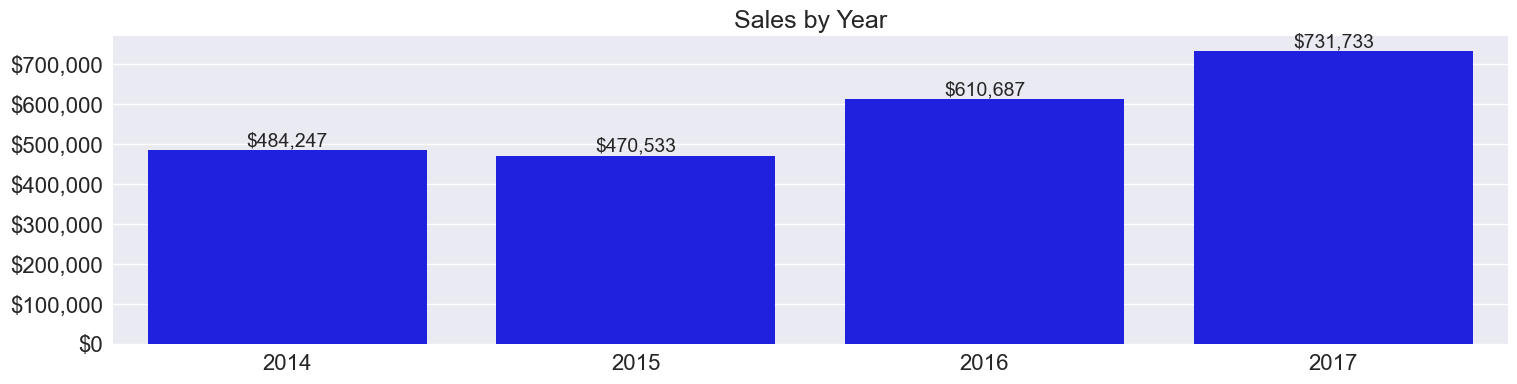

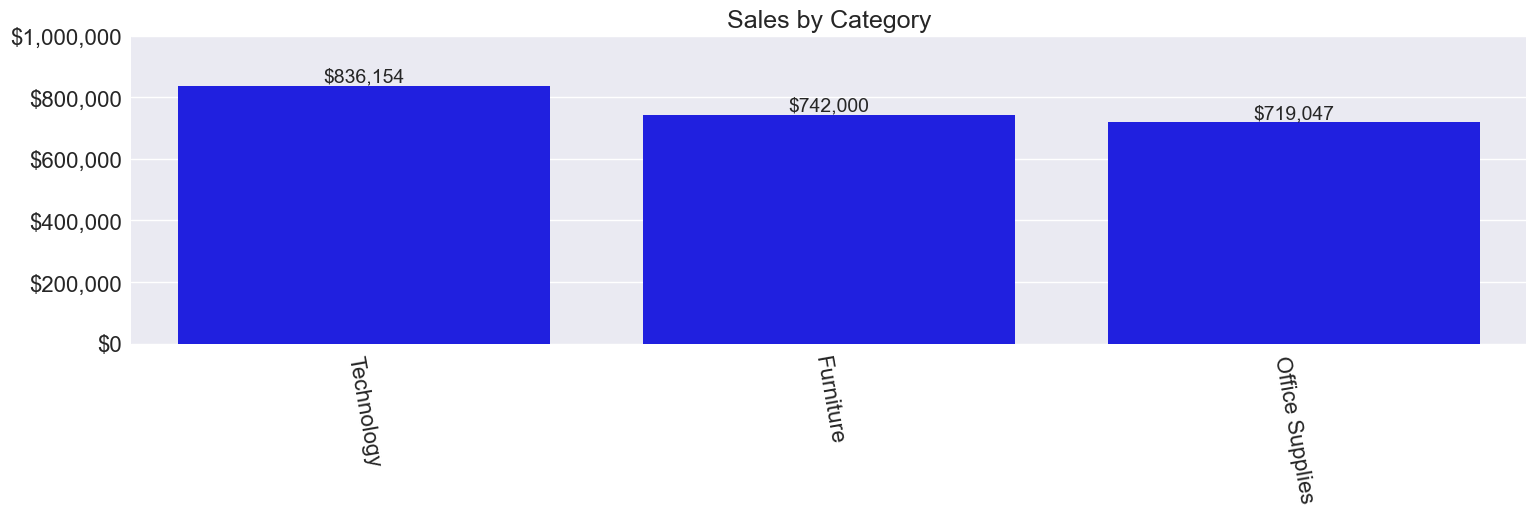

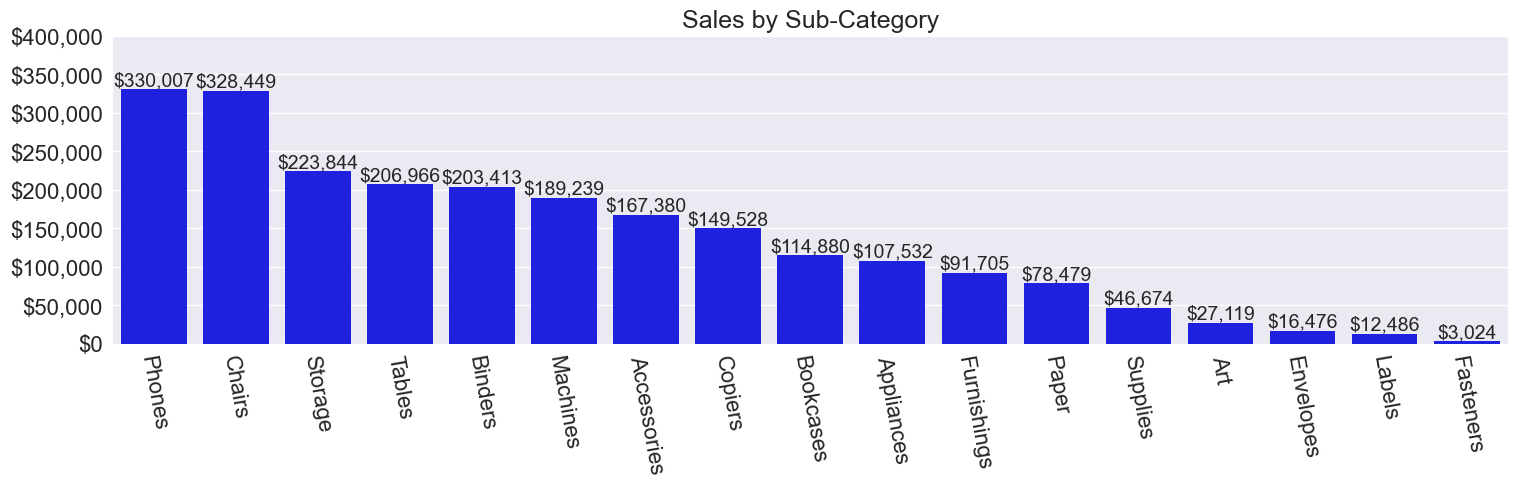

Sales  Quantity       Price     year  \
Category        Sub-Category                                               
Furniture       Bookcases     114879.9963       868  29890.8346   459589   
                Chairs        328449.1030      2356  85641.1250  1243670   
                Furnishings    91705.1640      3563  24506.2940  1929057   
                Tables        206965.5320      1241  52663.2675   643008   
Office Supplies Appliances    107532.1610      1729  28248.2950   939340   
                Art            27118.7920      3000   7019.1880  1604522   
                Binders       203412.7330      5974  55851.8810  3069967   
                Envelopes      16476.4020       906   4794.2100   511960   
                Fasteners       3024.2800       914    713.6600   437392   
                Labels         12486.3120      1400   3028.6340   733709   
                Paper          78479.2060      5178  21343.1720  2761561   
                Storage       223843.6080      3158  59601.9340  1705298   
                Supplies       46673.5380       647  13168.5400   382988   
Technology      Accessories   167380.3180      2976  42901.3880  1562213   
                Copiers       149528.0300       234  40869.4300   137070   
                Machines      189238.6310       440  48685.5340   231797   
                Phones        330007.0540      3289  89902.7860  1791977   

                              month  yearmonth   week  dayofweek   yearweek  
Category        Sub-Category                                                 
Furniture       Bookcases      1745   45960645   7095        747   45965995  
                Chairs         4979  124372079  20557       1897  124387557  
                Furnishings    7544  192913544  30881       2993  192936581  
                Tables         2524   64303324  10324        966   64311124  
Office Supplies Appliances     3665   93937765  15018       1551   93949018  
                Art            6002  160458302  24574       2517  160476774  
                Binders       11860  307008860  48270       5034  307044970  
                Envelopes      1991   51197991   8061        837   51204061  
                Fasteners      1696   43740896   6936        679   43746136  
                Labels         2779   73373679  11228       1264   73382128  
                Paper         10710  276166810  43826       4362  276199926  
                Storage        6669  170536569  27205       2667  170557005  
                Supplies       1502   38300302   6098        615   38304898  
Technology      Accessories    6170  156227470  24922       2506  156246222  
                Copiers         534   13707534   2185        227   13709185  
                Machines        897   23180597   3574        358   23183274  
                Phones         6783  179204483  27463       2824  179225163

In [5]:
df_sales_year = df_sales.groupby(["year"])["Sales"].sum().reset_index()
bp.barplot(df_sales_year,"year", "Sales" ,
                   title='Sales by Year', figsize=(18,4), color="blue",
                   bardatalabels=True, barcurrency="$", bardataformat=",.0f")


df_sales_category = df_sales.groupby("Category").sum().reset_index().sort_values("Sales",ascending=False)
bp.barplot(df_sales_category,'Category','Sales', x_tick_rotation=-80, y_lims=(0,1000000),
                   title='Sales by Category', figsize=(18,4), color="blue",
                   bardatalabels=True, barcurrency="$", bardataformat=",.0f")


df_sales_subcategory = df_sales.groupby("Sub-Category").sum().reset_index().sort_values("Sales",ascending=False)
bp.barplot(df_sales_subcategory,'Sub-Category','Sales', x_tick_rotation=-80, y_lims=(0,400000),
                   title='Sales by Sub-Category', figsize=(18,4), color="blue",
                   bardatalabels=True, barcurrency="$", bardataformat=",.0f")

df_sales_category_subcategory = df_sales.groupby(["Category","Sub-Category"]).sum()
df_sales_category_subcategory.head(20)

# Aggregate Daily and Weekly Sales ... Total, Category,  Sub Category

In [16]:

aggs = {
    "Sales":"sum",
    "Quantity":"sum",
    "year":"last",
    "week":"last",
    "dayofweek":"last",
    "dayname":"last",
    "month":"last",
    "yearweek":"last",
    "yearmonth":"last"

}

# sales daily
print("\ndf_totalsales_day")
df_totalsales_day = df_sales.groupby(["Order Date"]).agg(aggs).reset_index().sort_values(["Order Date"],ascending=True)
display(df_totalsales_day.head())

print("\ndf_catsales_day")
df_catsales_day = df_sales.groupby(["Order Date", "Category" ]).agg(aggs).reset_index().sort_values(["Order Date", "Category"],ascending=True)
display(df_catsales_day.head())

print("\ndf_scatsales_day")
df_scatsales_day = df_sales.groupby(["Order Date", "Category", "Sub-Category" ]).agg(aggs).reset_index().sort_values(["Order Date", "Sub-Category"],ascending=True)
display(df_scatsales_day.head())


print("\ndf_prodsales_day")
df_prodsales_day = df_sales.groupby(["Order Date",  "Category", "Sub-Category", "Product ID" ]).agg(aggs).reset_index().sort_values(["Order Date", "Sub-Category"],ascending=True)
display(df_prodsales_day.head())

# sales weekly
print("\ndf_totalsales_week")
df_totalsales_week = df_sales.groupby(["yearweek_dt" ]).agg(aggs).reset_index().sort_values(["yearweek_dt"],ascending=True)
display(df_totalsales_week.head())

print("\ndf_catsales_week")
df_catsales_week = df_sales.groupby(["yearweek_dt", "Category" ]).agg(aggs).reset_index().sort_values(["yearweek_dt", "Category"],ascending=True)
display(df_catsales_week.head())

print("\ndf_scatsales_week")
df_scatsales_week = df_sales.groupby(["yearweek_dt", "Category"  , "Sub-Category" ]).agg(aggs).reset_index().sort_values(["yearweek_dt", "Sub-Category"],ascending=True)
display(df_scatsales_week.head())

print("\ndf_prodsales_week")
df_prodsales_week = df_sales.groupby(["yearweek_dt", "Category"  , "Sub-Category", "Product ID"  ]).agg(aggs).reset_index().sort_values(["yearweek_dt", "Sub-Category"],ascending=True)
display(df_prodsales_week.head())


df_totalsales_day


,Order Date,Sales,Quantity,year,week,dayofweek,dayname,month,yearweek,yearmonth
0,2014-01-03,16.448,2,2014,1,4,Friday,1,201401,201401
1,2014-01-04,288.060,8,2014,1,5,Saturday,1,201401,201401
2,2014-01-05,19.536,3,2014,1,6,Sunday,1,201401,201401
3,2014-01-06,4407.100,30,2014,2,0,Monday,1,201402,201401
4,2014-01-07,87.158,10,2014,2,1,Tuesday,1,201402,201401



df_catsales_day


,Order Date,Category,Sales,Quantity,year,week,dayofweek,dayname,month,yearweek,yearmonth
0,2014-01-03,Office Supplies,16.448,2,2014,1,4,Friday,1,201401,201401
1,2014-01-04,Office Supplies,288.060,8,2014,1,5,Saturday,1,201401,201401
2,2014-01-05,Office Supplies,19.536,3,2014,1,6,Sunday,1,201401,201401
3,2014-01-06,Furniture,2573.820,9,2014,2,0,Monday,1,201402,201401
4,2014-01-06,Office Supplies,685.340,15,2014,2,0,Monday,1,201402,201401



df_scatsales_day


,Order Date,Category,Sub-Category,Sales,Quantity,year,week,dayofweek,dayname,month,yearweek,yearmonth
0,2014-01-03,Office Supplies,Paper,16.448,2,2014,1,4,Friday,1,201401,201401
1,2014-01-04,Office Supplies,Binders,3.540,2,2014,1,5,Saturday,1,201401,201401
2,2014-01-04,Office Supplies,Labels,11.784,3,2014,1,5,Saturday,1,201401,201401
3,2014-01-04,Office Supplies,Storage,272.736,3,2014,1,5,Saturday,1,201401,201401
4,2014-01-05,Office Supplies,Art,19.536,3,2014,1,6,Sunday,1,201401,201401



df_prodsales_day


,Order Date,Category,Sub-Category,Product ID,Sales,Quantity,year,week,dayofweek,dayname,month,yearweek,yearmonth
0,2014-01-03,Office Supplies,Paper,OFF-PA-10000174,16.448,2,2014,1,4,Friday,1,201401,201401
1,2014-01-04,Office Supplies,Binders,OFF-BI-10004094,3.540,2,2014,1,5,Saturday,1,201401,201401
2,2014-01-04,Office Supplies,Labels,OFF-LA-10003223,11.784,3,2014,1,5,Saturday,1,201401,201401
3,2014-01-04,Office Supplies,Storage,OFF-ST-10002743,272.736,3,2014,1,5,Saturday,1,201401,201401
4,2014-01-05,Office Supplies,Art,OFF-AR-10003478,19.536,3,2014,1,6,Sunday,1,201401,201401



df_totalsales_week


,yearweek_dt,Sales,Quantity,year,week,dayofweek,dayname,month,yearweek,yearmonth
0,2014-01-06,9822.061,186,2014,1,2,Wednesday,12,201401,201412
1,2014-01-13,4599.572,49,2014,2,5,Saturday,1,201402,201401
2,2014-01-20,4509.127,99,2014,3,6,Sunday,1,201403,201401
3,2014-01-27,3842.388,108,2014,4,6,Sunday,1,201404,201401
4,2014-02-03,1642.310,33,2014,5,6,Sunday,2,201405,201402



df_catsales_week


,yearweek_dt,Category,Sales,Quantity,year,week,dayofweek,dayname,month,yearweek,yearmonth
0,2014-01-06,Furniture,3251.464,40,2014,1,2,Wednesday,12,201401,201412
1,2014-01-06,Office Supplies,1912.635,87,2014,1,2,Wednesday,12,201401,201412
2,2014-01-06,Technology,4657.962,59,2014,1,2,Wednesday,12,201401,201412
3,2014-01-13,Furniture,2712.428,15,2014,2,5,Saturday,1,201402,201401
4,2014-01-13,Office Supplies,708.004,25,2014,2,4,Friday,1,201402,201401



df_scatsales_week


,yearweek_dt,Category,Sub-Category,Sales,Quantity,year,week,dayofweek,dayname,month,yearweek,yearmonth
11,2014-01-06,Technology,Accessories,2079.822,25,2014,1,2,Wednesday,12,201401,201412
4,2014-01-06,Office Supplies,Appliances,171.300,8,2014,1,1,Tuesday,12,201401,201412
5,2014-01-06,Office Supplies,Art,59.056,13,2014,1,2,Wednesday,12,201401,201412
6,2014-01-06,Office Supplies,Binders,607.611,20,2014,1,1,Tuesday,12,201401,201412
0,2014-01-06,Furniture,Bookcases,1915.448,9,2014,1,2,Wednesday,12,201401,201412



df_prodsales_week


,yearweek_dt,Category,Sub-Category,Product ID,Sales,Quantity,year,week,dayofweek,dayname,month,yearweek,yearmonth
33,2014-01-06,Technology,Accessories,TEC-AC-10000290,47.53,7,2014,1,2,Wednesday,12,201401,201412
34,2014-01-06,Technology,Accessories,TEC-AC-10000358,113.97,3,2014,1,2,Wednesday,12,201401,201412
35,2014-01-06,Technology,Accessories,TEC-AC-10001267,119.80,4,2014,1,0,Monday,12,201401,201412
36,2014-01-06,Technology,Accessories,TEC-AC-10002049,1687.80,4,2014,1,2,Wednesday,12,201401,201412
37,2014-01-06,Technology,Accessories,TEC-AC-10003614,34.77,3,2014,1,2,Wednesday,12,201401,201412


# Sales Revenue Lineplots

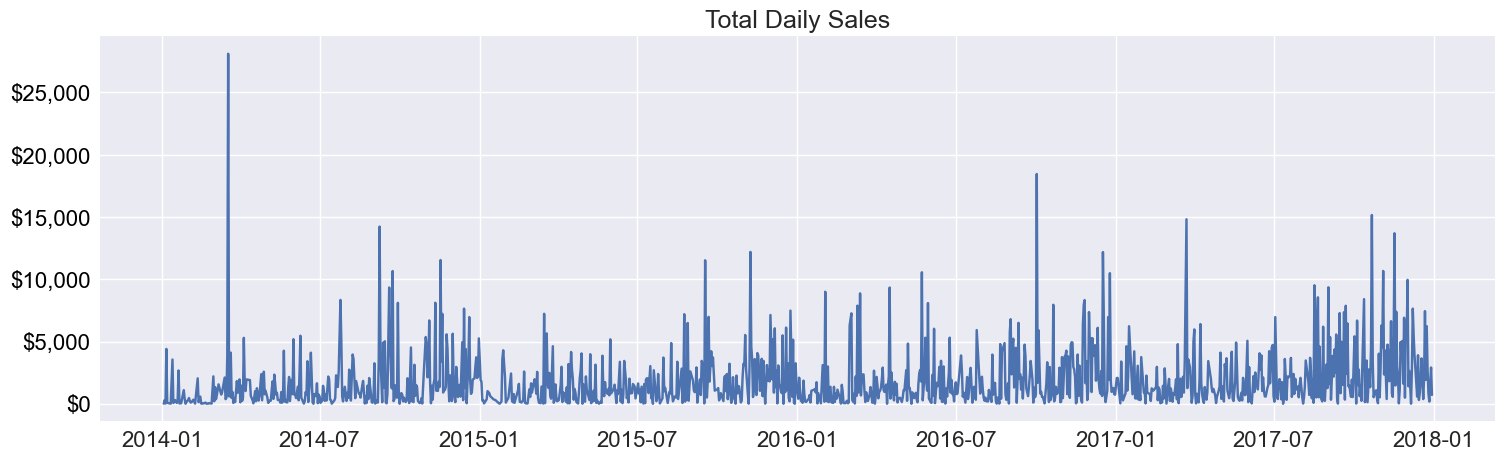

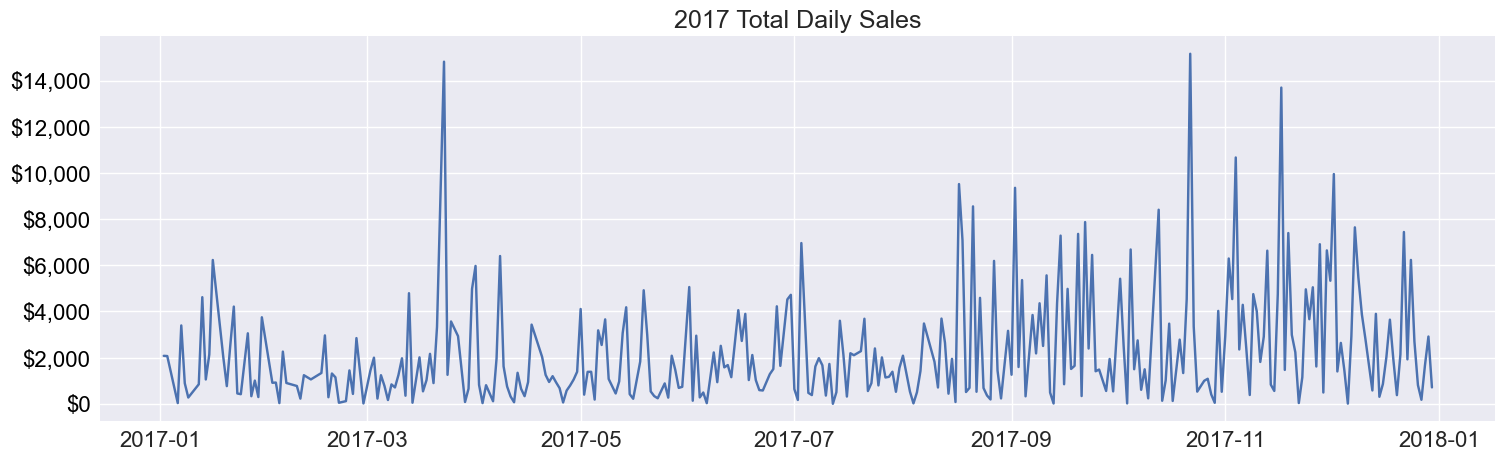

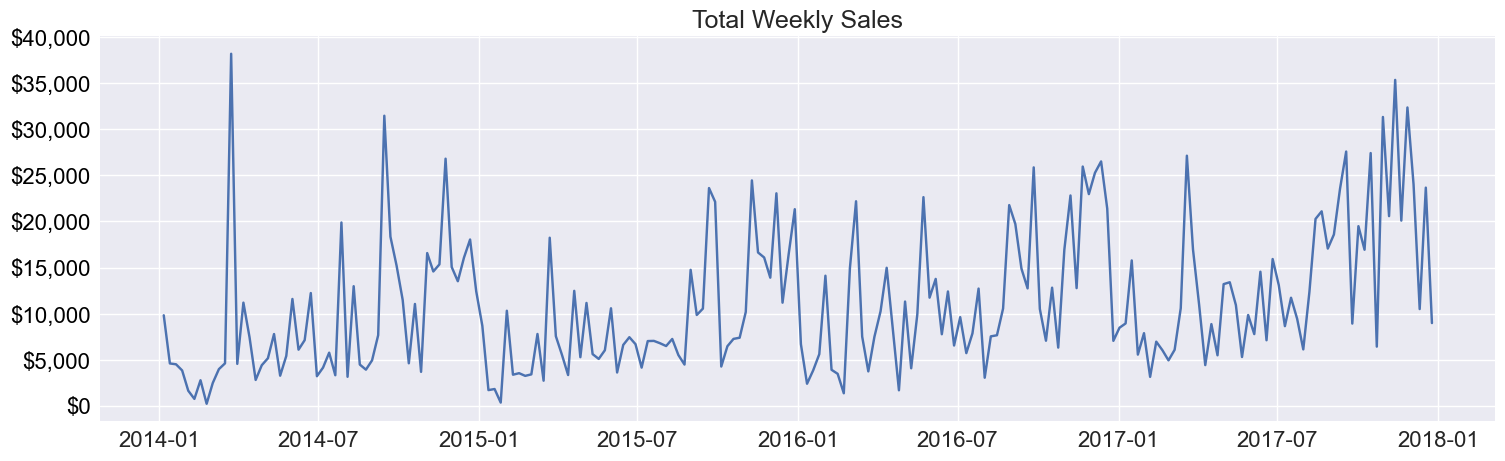

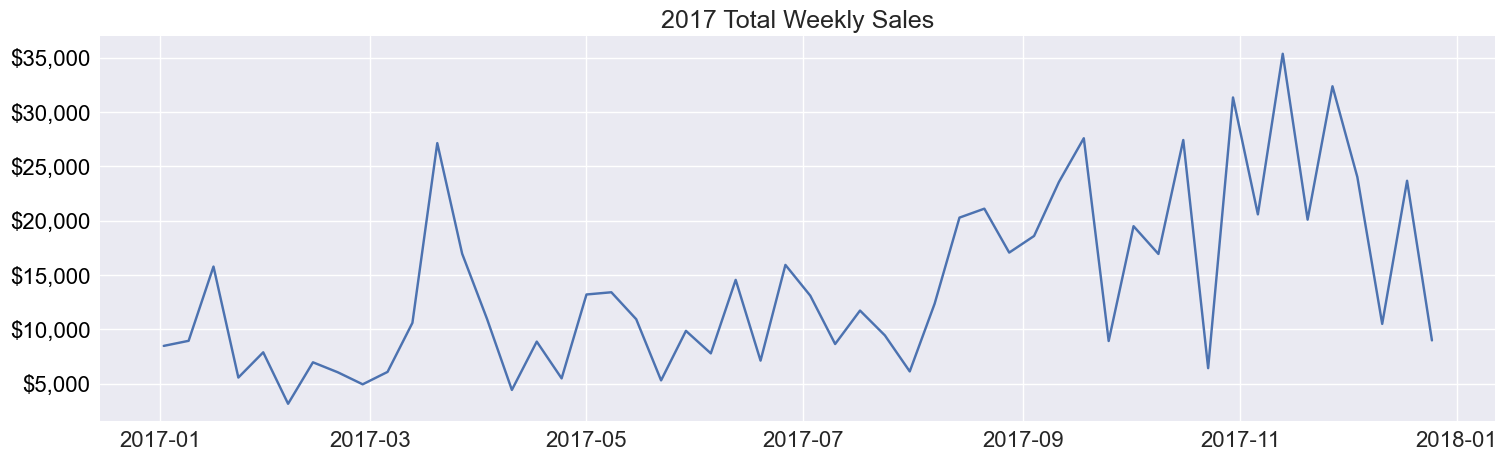

In [17]:

bp.lineplot(df_totalsales_day,"Order Date","Sales",figsize=(18,5), 
             y_axis_format = ",.0f", y_currency = "$" , title = "Total Daily Sales")

bp.lineplot(df_totalsales_day[df_totalsales_day["year"]==2017],"Order Date","Sales",figsize=(18,5),
             y_axis_format = ",.0f", y_currency = "$" , title = "2017 Total Daily Sales" )


bp.lineplot(df_totalsales_week,"yearweek_dt","Sales",figsize=(18,5), 
             y_axis_format = ",.0f", y_currency = "$" , title = "Total Weekly Sales")

bp.lineplot(df_totalsales_week[df_totalsales_week["year"]==2017],"yearweek_dt","Sales",figsize=(18,5),
           y_axis_format = ",.0f", y_currency = "$" , title = "2017 Total Weekly Sales" )

# Category Sales Revenue Lineplots

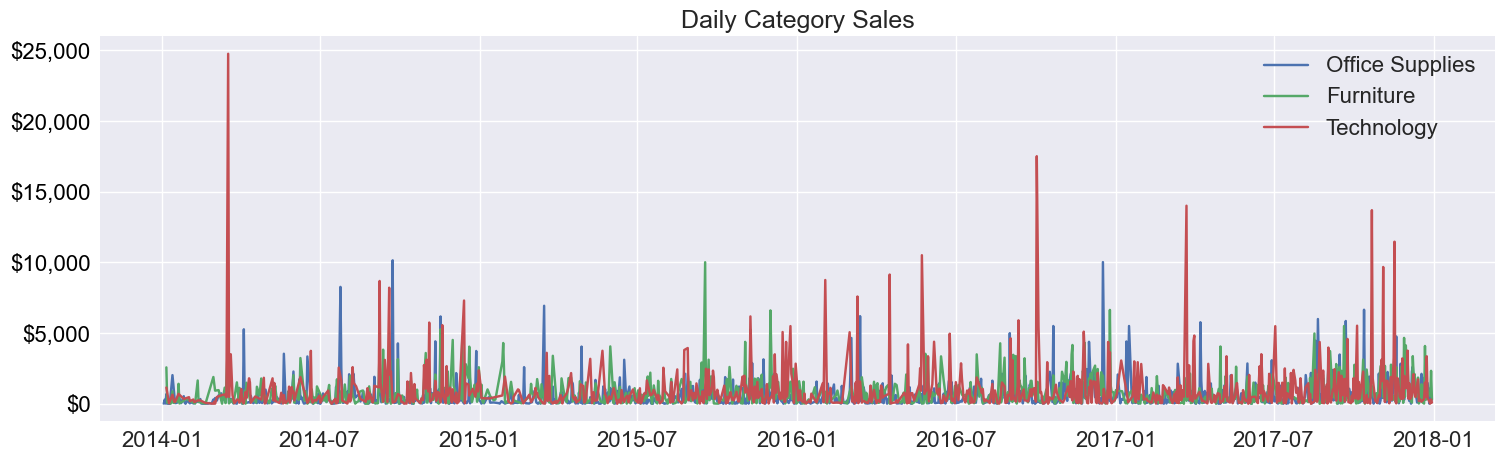

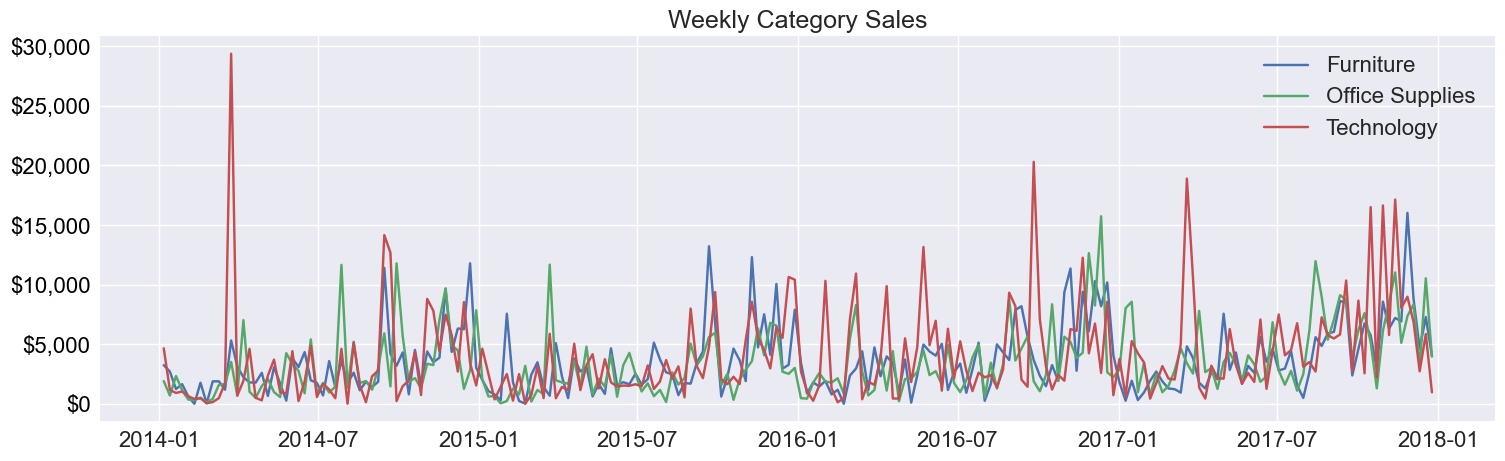

In [18]:

bp.lineplot(df_catsales_day,"Order Date","Sales",hue="Category",  y_axis_format = ",.0f", y_currency = "$" ,
            title = "Daily Category Sales", figsize=(18,5))



bp.lineplot(df_catsales_week,"yearweek_dt","Sales",hue="Category",  y_axis_format = ",.0f", y_currency = "$" ,
            title = "Weekly Category Sales", figsize=(18,5))



# Category Sales Quanity

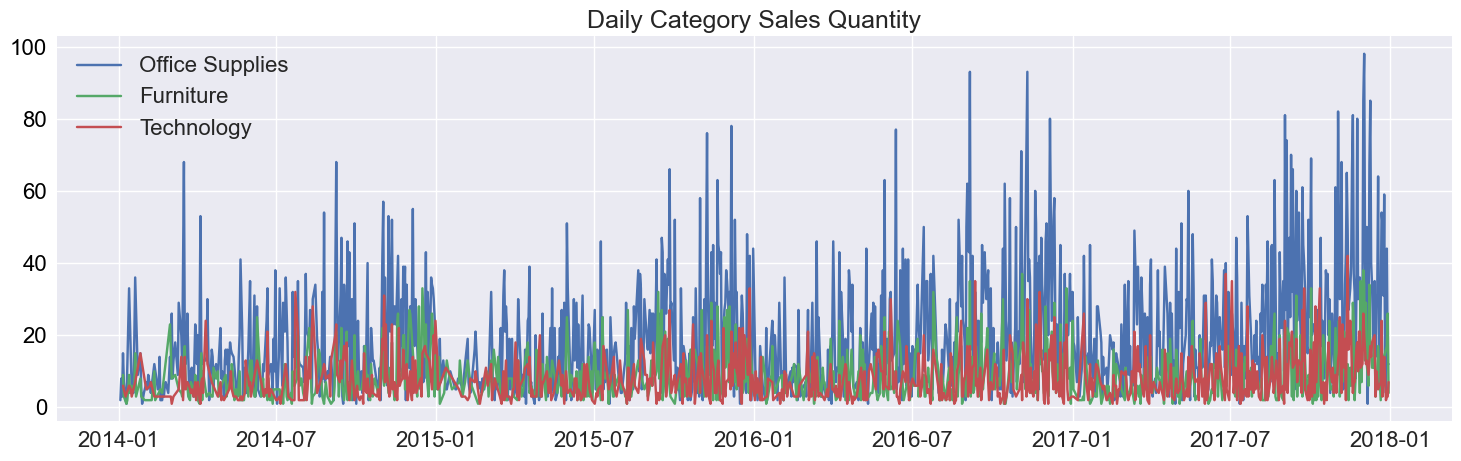

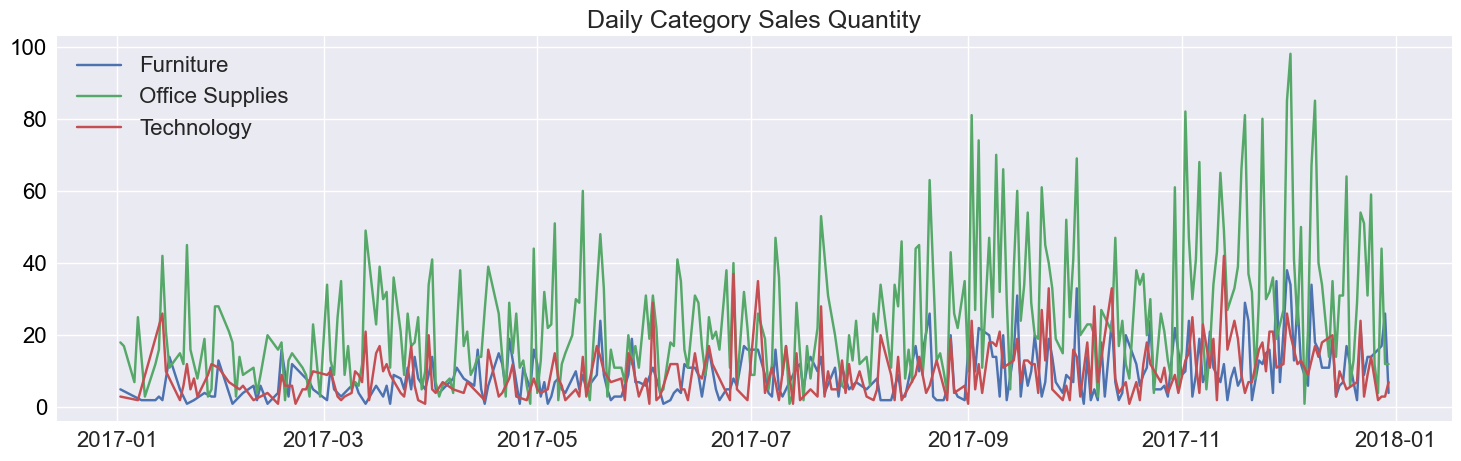

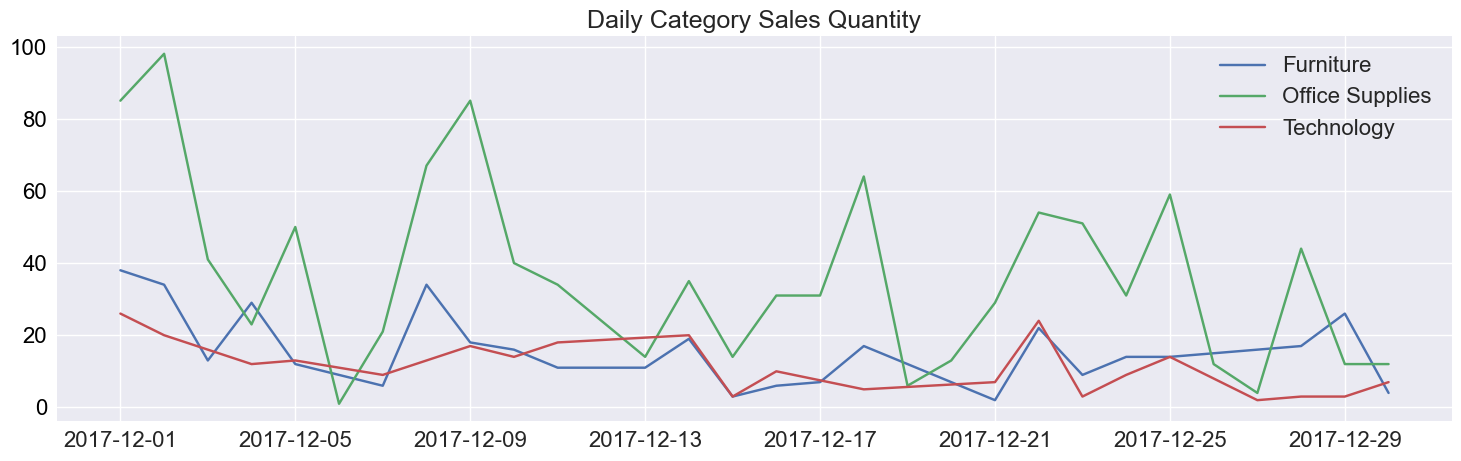

In [19]:

bp.lineplot(df_catsales_day,"Order Date","Quantity",hue="Category",  y_axis_format = ",.0f" , 
            title = "Daily Category Sales Quantity", figsize=(18,5))


bp.lineplot(df_catsales_day[df_catsales_day["year"]==2017],"Order Date","Quantity",hue="Category",  y_axis_format = ",.0f" , 
            title = "Daily Category Sales Quantity", figsize=(18,5))

d=datetime(2017,12,1)
bp.lineplot(df_catsales_day[df_catsales_day["Order Date"]>=d],"Order Date","Quantity",hue="Category",  y_axis_format = ",.0f" , 
            title = "Daily Category Sales Quantity", figsize=(18,5))

# Contiguous Dates

Not all categories have sales on each day. 

Some days there are no sales at all.


For example:
* on 2017-1-1 Sun no Technology sales
* on 2017-1-3 Tues no Furniture nor Technology sales
* some days there are no sales reported
   * 2016-01-06 Wed  no sales
   * 2017-01-04 Wed  no sales
   * 2017-01-05 Thur no sales
   
   
Create contiguous dates for this set, with 0's for dates where there are no sales so that forecast periods do not skip dates


In [20]:
s = datetime(2017,1,1)
e = datetime(2017,1,10)
df_catsales_day[ (df_catsales_day["Order Date"]>=s) & (df_catsales_day["Order Date"]<=e)].head(20)


,Order Date,Category,Sales,Quantity,year,week,dayofweek,dayname,month,yearweek,yearmonth
2050,2017-01-01,Furniture,975.490,24,2016,52,6,Sunday,1,201652,201701
2051,2017-01-01,Office Supplies,506.338,32,2016,52,6,Sunday,1,201652,201701
2052,2017-01-02,Furniture,913.430,5,2017,1,0,Monday,1,201701,201701
2053,2017-01-02,Office Supplies,453.834,18,2017,1,0,Monday,1,201701,201701
2054,2017-01-02,Technology,712.290,3,2017,1,0,Monday,1,201701,201701
2055,2017-01-03,Office Supplies,2070.272,17,2017,1,1,Tuesday,1,201701,201701
2056,2017-01-06,Office Supplies,33.740,7,2017,1,4,Friday,1,201701,201701
2057,2017-01-07,Office Supplies,335.608,25,2017,1,5,Saturday,1,201701,201701
2058,2017-01-07,Technology,3059.982,2,2017,1,5,Saturday,1,201701,201701
2059,2017-01-08,Furniture,892.980,2,2017,1,6,Sunday,1,201701,201701


In [21]:
def reindex_orders_by_date(df,order_dimensions,units,revenue,freq="D"):
    
    less_days=0
    sdate=df.index.min()
    edate=df.index.max()
    # dates are specific to this order_dimension group
    dates = list(pd.date_range(pd.to_datetime(sdate),pd.to_datetime(edate)-pd.Timedelta(days=less_days),freq=freq))  
    df_reindexed = df.reindex(dates)
    ff_cols = order_dimensions 
    zf_cols = [units, revenue]
    df_reindexed[ff_cols] = df_reindexed[ff_cols].ffill()
    df_reindexed[zf_cols] = df_reindexed[zf_cols].fillna(0)
    return df_reindexed


def orders_contiguous_demand_periods(df, order_dimensions=['product_id','seller_id'], date='date', units='units', revenue = "sales", freq="D",
                         verbose=False):

    # assumes that sales are already aggregated to the "date" field
    #   df
    #   sale dimensions ...  product id seller id
    #   date column (datetime type)
    #   units
    #   freq - D or 7D

    orders_contiguous = df.copy().set_index(date)
    # reindex date, groupby
    #https://stackoverflow.com/questions/32275540/pandas-reindex-dates-in-groupby
    

    orders_contiguous = orders_contiguous.groupby(order_dimensions).apply(reindex_orders_by_date,order_dimensions,units,revenue,freq=freq)
    
    dlevels = [i for i in range(len(order_dimensions))]
    orders_contiguous = orders_contiguous.droplevel(level=dlevels)

    
    orders_contiguous = orders_contiguous.reset_index().sort_values(date,ascending=True)

    
    return orders_contiguous

#### category sales contiguous demand period

In [50]:


dp = "Order Date" # demand period
sales_type = "category"  # detail level

if sales_type == "product" and dp == "Order Date":
    _df = df_prodsales_day
    order_dims = ["Category" ,"Sub-Category" , "Product ID" ]
elif sales_type == "subcategory" and dp == "Order Date": 
    _df = df_scatsales_day
    order_dims = ["Category" ,"Sub-Category"  ]
elif sales_type == "category" and dp == "Order Date": 
    _df = df_catsales_day
    order_dims = ["Category" ]
else:
    _df = df_prodsales_day

print(f'demand period = {dp}')
print(f'sales_type = {sales_type}')
    
df_sales_cdp = orders_contiguous_demand_periods(_df, order_dimensions=order_dims,
                                        date = dp, units = "Quantity", revenue="Sales")



df_sales_cdp["year"]=df_sales_cdp[dp].dt.year
df_sales_cdp['month']=df_sales_cdp[dp].dt.month 
# do yearmonth before adjusting year ... NOTE yearmonth is needed for joining outside datasets like CCI
df_sales_cdp['yearmonth'] = df_sales_cdp['year']*100 + df_sales_cdp['month']
df_sales_cdp['week']=df_sales_cdp["Order Date"].dt.isocalendar().week 
df_sales_cdp['dayofweek']=df_sales_cdp["Order Date"].dt.dayofweek 
df_sales_cdp['dayname']=df_sales_cdp["Order Date"].dt.day_name()
# fix year and week ... 
  # weeks must be <= 52 ... 
df_sales_cdp['week']=df_sales_cdp['week'].apply(lambda x: x if x < 53 else 1) # isocalendar may have 53 weeks, adds a year to the date !!!!!
  # year = year-1 if week == 52 .... week may have started in previous year

df_sales_cdp['year']=df_sales_cdp.apply(lambda row: row["year"]-1  if (row["week"]==52 )and (row["month"]==1) else row["year"],axis=1)
df_sales_cdp['yearweek']= df_sales_cdp['year']*100+df_sales_cdp['week']  



df_sales_cdp.head(10)

demand period = Order Date
sales_type = category


,Order Date,Category,Sales,Quantity,year,week,dayofweek,dayname,month,yearweek,yearmonth
1455,2014-01-03,Office Supplies,16.448,2.0,2014,1,4,Friday,1,201401,201401
1456,2014-01-04,Office Supplies,288.060,8.0,2014,1,5,Saturday,1,201401,201401
1457,2014-01-05,Office Supplies,19.536,3.0,2014,1,6,Sunday,1,201401,201401
0,2014-01-06,Furniture,2573.820,9.0,2014,2,0,Monday,1,201402,201401
1458,2014-01-06,Office Supplies,685.340,15.0,2014,2,0,Monday,1,201402,201401
2913,2014-01-06,Technology,1147.940,6.0,2014,2,0,Monday,1,201402,201401
1,2014-01-07,Furniture,76.728,3.0,2014,2,1,Tuesday,1,201402,201401
1459,2014-01-07,Office Supplies,10.430,7.0,2014,2,1,Tuesday,1,201402,201401
2914,2014-01-07,Technology,0.000,0.0,2014,2,1,Tuesday,1,201402,201401
2,2014-01-08,Furniture,0.000,0.0,2014,2,2,Wednesday,1,201402,201401


In [41]:
s = datetime(2017,1,1)
e = datetime(2017,1,10)
df_sales_cdp[ (df_sales_cdp["Order Date"]>=s) & (df_sales_cdp["Order Date"]<=e)].head(20)


,Order Date,Category,Sub-Category,Product ID,Sales,Quantity,year,week,dayofweek,dayname,month,yearweek,yearmonth
1538396,2017-01-01,Technology,Phones,TEC-PH-10000984,0.0,0.0,2016,52,6,Sunday,1,201652,201701
892384,2017-01-01,Office Supplies,Fasteners,OFF-FA-10004395,0.0,0.0,2016,52,6,Sunday,1,201652,201701
1275158,2017-01-01,Office Supplies,Storage,OFF-ST-10002574,0.0,0.0,2016,52,6,Sunday,1,201652,201701
541290,2017-01-01,Office Supplies,Art,OFF-AR-10003582,0.0,0.0,2016,52,6,Sunday,1,201652,201701
1331700,2017-01-01,Office Supplies,Supplies,OFF-SU-10001574,0.0,0.0,2016,52,6,Sunday,1,201652,201701
352044,2017-01-01,Furniture,Tables,FUR-TA-10004915,0.0,0.0,2016,52,6,Sunday,1,201652,201701
1293224,2017-01-01,Office Supplies,Storage,OFF-ST-10003442,0.0,0.0,2016,52,6,Sunday,1,201652,201701
291298,2017-01-01,Furniture,Furnishings,FUR-FU-10004909,0.0,0.0,2016,52,6,Sunday,1,201652,201701
1120747,2017-01-01,Office Supplies,Paper,OFF-PA-10003129,0.0,0.0,2016,52,6,Sunday,1,201652,201701
956917,2017-01-01,Office Supplies,Labels,OFF-LA-10004689,0.0,0.0,2016,52,6,Sunday,1,201652,201701


In [33]:
df_sales_cdp.columns

Index(['Order Date', 'Category', 'Sub-Category', 'Sales', 'Quantity', 'year',
       'week', 'dayofweek', 'dayname', 'month', 'yearweek', 'yearmonth'],
      dtype='object')

# Save File

In [51]:
# Product Sales

if sales_type == "product" and dp == "Order Date":
    filename = "superstore_prodsales_cdp.csv"
elif sales_type == "subcategory" and dp == "Order Date": 
    filename = "superstore_subcatsales_cdp.csv"
elif sales_type == "category" and dp == "Order Date": 
    filename = "superstore_catsales_cdp.csv"
else:
    filename = "superstore_prodsales_cdp.csv"
    
print(f'df_sales_cdp.shape = {df_sales_cdp.shape}')
print( f'save {filename} ...')
df_sales_cdp.to_csv(f'../data/{filename}',index=False)


df_sales_cdp.shape = (4368, 11)
save superstore_catsales_cdp.csv ...


In [46]:
#... for github
# forecast examples  
# subcategory only!!!!! 
#cols=['Order Date', 'Category', 'Sub-Category',  'Sales','Quantity']
#df_sales_cdp[cols].to_csv(f'../data/Superstore_subcatsales_2017_cdp.csv',index=False)